In [6]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
sys.path.append("../..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import json
import math
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
import matplotlib.pyplot as plt
import matplotlib.cm

In [11]:
%env OPENAI_API_KEY="g"

env: OPENAI_API_KEY="g"


In [12]:
# log_dir = "/Users/patrickjohnchia/Desktop/Projects/negotiation/.logs/split_the_difference/"
log_dir_default = ".logs/split_the_difference"
log_dir_over_valued = ".logs/over_valued_buyer"
log_dir_over_valued_prompted = ".logs/over_valued_buyer_self_interested/"

game_states_default = load_states_from_dir(log_dir_default)
game_states_over_valued = load_states_from_dir(log_dir_over_valued)
game_states_ov_prompted = load_states_from_dir(log_dir_over_valued_prompted)


THERE ARE 100 log files
100 Loaded Successfully
THERE ARE 100 log files
100 Loaded Successfully
THERE ARE 100 log files
100 Loaded Successfully


In [13]:
def get_bad_proposal_rate(game_states):
    game_states = [ g for g in game_states if len(g.game_state) >=2]
    # extract trade object
    trade_proposals = [[ _['player_public_info_dict']['newly proposed trade'] for _ in  g.game_state[1:-1]] for g in game_states] 
    # extract ZUP remove none
    trade_proposals = [[ _.resources_from_second_agent.resource_dict['ZUP'] if _ != "NONE" else 0 for _ in tp ] for tp in trade_proposals]
    # get sequences long enough
    trade_proposals = [tp for tp in trade_proposals if len(tp) >= 2]
    # get first two proposals
    trade_proposals = [tp[:2] for tp in trade_proposals]
    # flatten
    trade_proposals = np.array(trade_proposals)
    bad_proposal_rate=  np.average(trade_proposals[:,1] > trade_proposals[:, 0])
    trade_proposals, bad_proposal_rate
    return bad_proposal_rate


In [36]:
sd = lambda x : (((1-x)*x/100)**0.5)
over_valued_bpr = get_bad_proposal_rate(game_states_over_valued)
default_bpr = get_bad_proposal_rate(game_states_default)
over_valued_prompted_bpr = get_bad_proposal_rate(game_states_ov_prompted)
print(default_bpr, over_valued_bpr, over_valued_prompted_bpr)
print(sd(default_bpr), sd(over_valued_bpr), sd(over_valued_prompted_bpr))

0.11 0.41 0.46
0.03128897569432403 0.04918333050943175 0.04983974317750845


In [15]:
from scipy.stats import binomtest

binomtest(int(over_valued_bpr*100), n=100, p=default_bpr, alternative='greater')


BinomTestResult(k=41, n=100, alternative='greater', statistic=0.41, pvalue=1.2495157706022893e-14)

In [26]:
import seaborn as sns
sns.set_context('poster')
sns.set_palette('colorblind')

In [33]:
from scipy.stats import sem

0.11

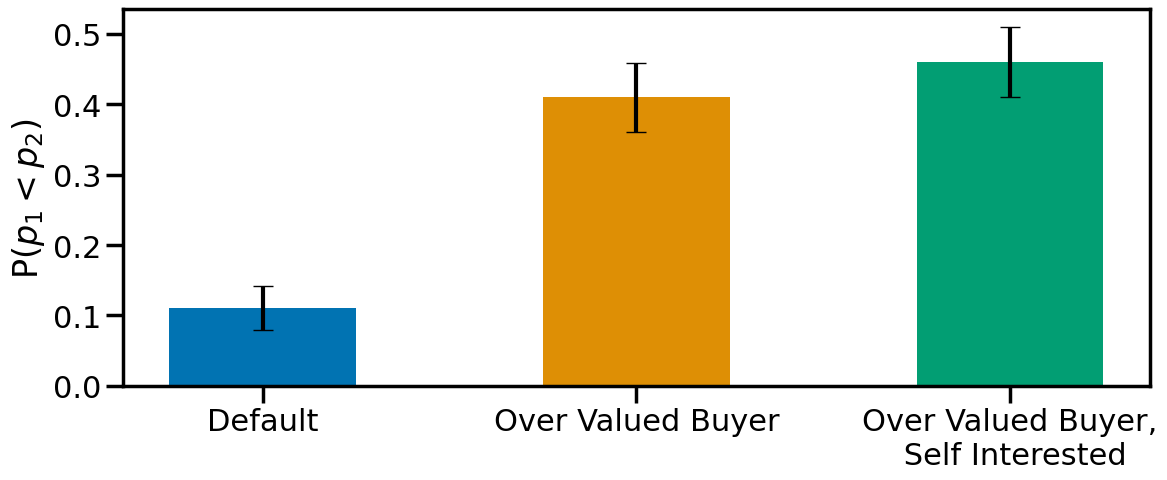

In [38]:
plt.rcParams.update({'font.size': 13})
fig,ax = plt.subplots(figsize=(12,5))
ax.bar(
    [
      "Default",
      "Over Valued Buyer",
      "Over Valued Buyer,\n Self Interested", 
    ],
        
    [
        default_bpr,
        over_valued_bpr,
        over_valued_prompted_bpr,
    ],
    yerr=[
        sd(default_bpr),
        sd(over_valued_bpr),
        sd(over_valued_prompted_bpr),
    ],
    capsize=7,
    color=sns.color_palette(n_colors=len([1,2,3])),
    width=0.5
)
ax.set_ylabel('P$(p_1 < p_2)$')
plt.tight_layout()
plt.savefig('over_valued_buyer.pdf')  